In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import cellrank as cr
import matplotlib.pyplot as plt

Global seed set to 0


In [2]:
adata = cr.datasets.reprogramming_morris(subset='48k')

In [3]:
adata.obs['exp_time'] = adata.obs['reprogramming_day'].astype(int)/np.max(adata.obs['reprogramming_day'].astype(int))

In [4]:
adata

AnnData object with n_obs × n_vars = 48515 × 22630
    obs: 'timecourse', 'reprogramming_day', 'reprogramming', 'cell_type', 'cell_cycle', 'cluster', 'monocle_state', 'pseudotime', 'CellTagD0_85k', 'CellTagD3_85k', 'CellTagD13_85k', 'CellTagD0_48k', 'CellTagD3_48k', 'CellTagD13_48k', 'exp_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'cell_cycle_colors', 'cluster_colors', 'reprogramming_colors', 'reprogramming_day_colors'
    obsm: 'X_diff', 'X_tsne'
    layers: 'spliced', 'unspliced'

In [5]:
import gc
gc.collect()
scv.pp.filter_genes(adata, min_shared_counts=30)
gc.collect()
adata = ltv.utils.anvi_clean_recipe(adata, celltype_key='cluster')
gc.collect()

Filtered out 12168 genes that are detected 30 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:23) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:08) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


19858

# fit celltype annotated model

In [6]:
model = ltv.models.AnnotVAE(observed=2000, latent_dim=20, zr_dim=1, h_dim=2, celltypes=10,
                            time_reg=True, exp_time=True, time_reg_weight=0.5, time_reg_decay=25)


In [9]:
del adata.layers['spliced_raw']
del adata.layers['unspliced_raw']

In [10]:
del adata.layers['Ms']
del adata.layers['Mu']

In [11]:
gc.collect()

0

In [12]:
adata

AnnData object with n_obs × n_vars = 48515 × 2000
    obs: 'timecourse', 'reprogramming_day', 'reprogramming', 'cell_type', 'cell_cycle', 'cluster', 'monocle_state', 'pseudotime', 'CellTagD0_85k', 'CellTagD3_85k', 'CellTagD13_85k', 'CellTagD0_48k', 'CellTagD3_48k', 'CellTagD13_48k', 'exp_time', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'spliced_size_factor', 'unspliced_size_factor', 'batch_id', 'celltype', 'celltype_id', 'root', 'terminal'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_genes'
    uns: 'cell_cycle_colors', 'cluster_colors', 'reprogramming_colors', 'reprogramming_day_colors', 'pca', 'neighbors', 'scale_spliced', 'scale_unspliced'
    obsm: 'X_diff', 'X_tsne', 'X_pca', 'batch_onehot', 'celltype'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'spliced_counts', 'unspliced_counts', 'mask_spliced', 'mask_unspliced'
    obsp: 'distances', 'connectivities', 'adj'

In [13]:
epochs, val_ae, val_traj, _,_ = ltv.train_anvi(model, adata, batch_size = 100,
                                      epochs=0, name='reprogramming_parameters', grad_clip=1000, timing=True)

Warning, folder already exists. This may overwrite a previous fit.
1157 velocity genes used
Loading best model at 0 epochs.


In [16]:
import torch as th
model.load_state_dict(th.load('reprogramming_parameters/model_state_epoch23.params',map_location=th.device('cuda')))

<All keys matched successfully>

In [17]:
gc.collect()

9

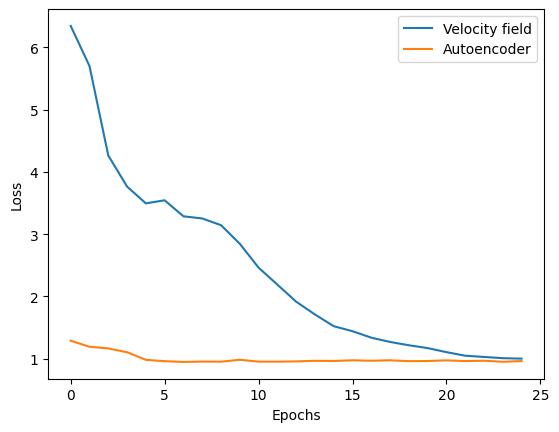

In [8]:
ltv.plot_history(epochs, val_ae, val_traj)
plt.show()

In [19]:
gc.collect()

0

In [18]:
latent_adata, adata = ltv.output_results(model, adata, embedding='tsne',
                                        gene_velocity=True, decoded=True)

In [20]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/48515 [00:00<?, ?cells/s]

/home/spencer/.local/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:20) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:09) --> added
    'spliced_velocity_tsne', embedded velocity vectors (adata.obsm)
saving figure to file figures/model_morris_reprogramming_latent_time_May12.png


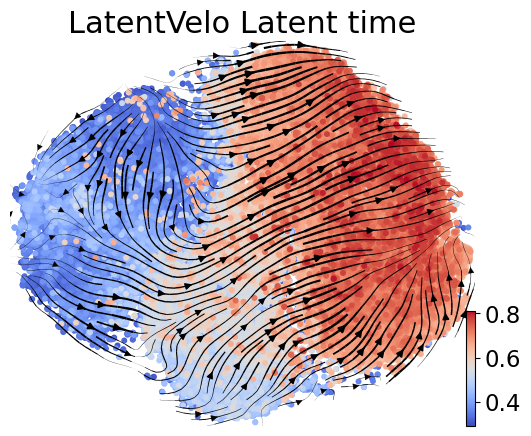

In [89]:
scv.pl.velocity_embedding_stream(latent_adata, basis='tsne',vkey='spliced_velocity',
                                 color=['latent_time'], color_map='coolwarm',
                                 title=['LatentVelo Latent time'], cutoff_perc=0,
                                 alpha=1, legend_fontsize=22, legend_fontoutline=3, fontsize=22,
                                figsize=(6,5), size=75, 
                                save='figures/model_morris_reprogramming_latent_time_May12.png')

In [91]:
from matplotlib.colors import Normalize,CenteredNorm, TwoSlopeNorm
norm = TwoSlopeNorm(0.8, vmin=-1, vmax=1.75)

saving figure to file figures/model_morris_reprogramming_nocelltype_May12.png


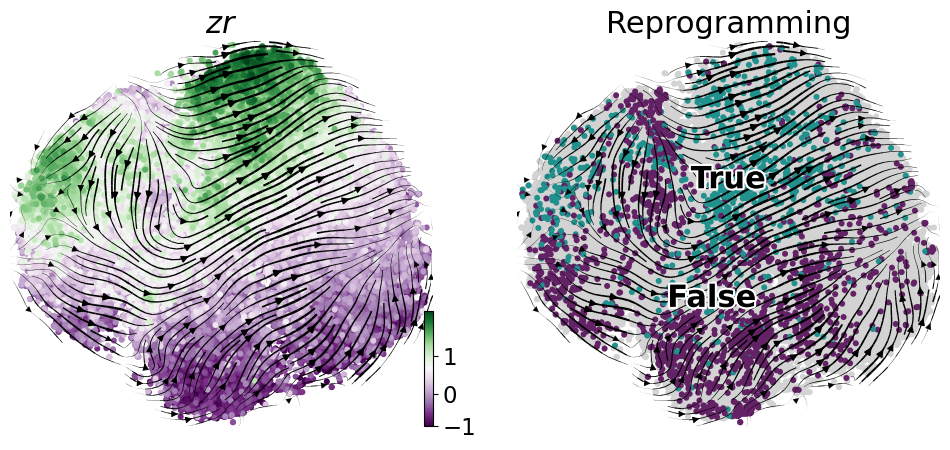

In [92]:
latent_adata.obs['zr1'] = latent_adata.obsm['zr'][:,0]
scv.pl.velocity_embedding_stream(latent_adata, basis='tsne',vkey='spliced_velocity',
                                color_map='PRGn',
                                 color=['zr1', 'reprogramming'],
                                 title=[r'$z_r$', 'Reprogramming'], 
                                 alpha=1, legend_fontsize=22, legend_fontoutline=3, fontsize=22,
                                 norm=norm, min_mass=0, cutoff_perc=0, size=75, figsize=(6,5),
                                save='figures/model_morris_reprogramming_nocelltype_May12.png')

# Trajectories

In [21]:
# clear memory
#del adata.layers['Mu']
#del adata.layers['Ms']
del adata.layers['spliced_counts']
del adata.layers['unspliced_counts']
del adata.layers['mask_spliced']
del adata.layers['mask_unspliced']

In [22]:
gc.collect()

393

In [23]:
# select fraction to use for 
selected = np.random.choice(adata.shape[0], size=10000, replace=False)

In [24]:
z_traj, times = ltv.cell_trajectories(model, adata[selected], time_steps=10)

In [58]:
adata.uns['reprogramming_colors']

array(['#642266', '#21918D'], dtype=object)

In [94]:
with th.no_grad():
    xhat =  model.decoder_s(z_traj[...,:model.latent].cuda()).cpu().numpy()
    xhat_dead_traj = xhat[dead_cells]
    xhat_reprogram_traj = xhat[reprogram_cells]

In [95]:
del xhat

In [96]:
gc.collect()

0

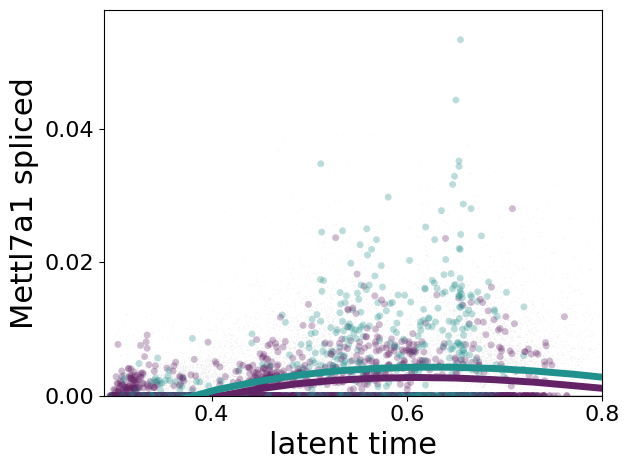

In [97]:
from scipy.stats import binned_statistic

fig,ax=plt.subplots()

x = xhat_dead_traj[:,:,np.where(adata.var.index.values=='Mettl7a1')[0]][...,0]
t = times[dead_cells,:,0].numpy()[x>-100]
x = x[x>-100]
dead_mean, bin_edges_dead, _ = binned_statistic(t, 
                                   x,statistic=np.mean, bins=20)
    
x = xhat_reprogram_traj[:,:,np.where(adata.var.index.values=='Mettl7a1')[0]][...,0]
t = times[reprogram_cells,:,0].numpy()[x>-100]
x = x[x>-100]
reprogram_mean, bin_edges_reprogram, _ = binned_statistic(t, 
                                   x, statistic=np.mean, bins=20)

plt.plot(bin_edges_dead[1:], dead_mean,
        color=adata.uns['reprogramming_colors'][0], zorder=100, linewidth=5)
plt.plot(bin_edges_reprogram[1:], reprogram_mean,
        color=adata.uns['reprogramming_colors'][1], zorder=100,linewidth=5)

scv.pl.scatter(adata, x='latent_time', y='Mettl7a1', color='reprogramming',
               ax=ax,show=False, layer='spliced', s=100, alpha=0.3,
              ylabel='Mettl7a1 spliced', title='',fontsize=22)
plt.ylim(0,)
plt.xlim(0.29,0.8)
plt.tight_layout()
plt.savefig('figures/Mettl7a1_trajectories_May12.png')
plt.show()

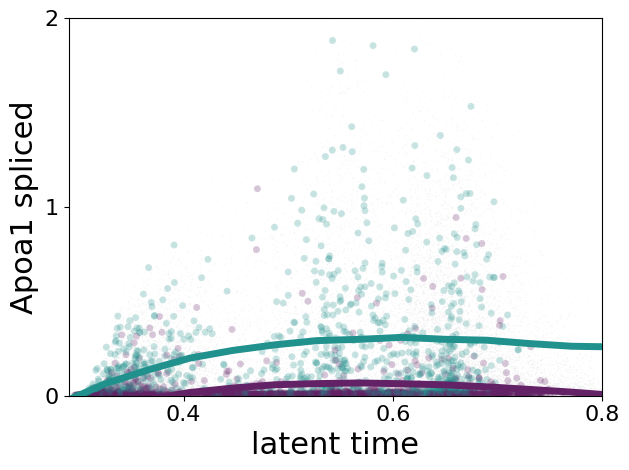

In [99]:
from scipy.stats import binned_statistic

fig,ax=plt.subplots()

x = xhat_dead_traj[:,:,np.where(adata.var.index.values=='Apoa1')[0]][...,0]
t = times[dead_cells,:,0].numpy()[x>-100]
x = x[x>-100]
dead_mean, bin_edges_dead, _ = binned_statistic(t,x,statistic=np.mean, bins=20)
    
    
x = xhat_reprogram_traj[:,:,np.where(adata.var.index.values=='Apoa1')[0]][...,0]
t = times[reprogram_cells,:,0].numpy()[x>-100]
x = x[x>-100]
reprogram_mean, bin_edges_reprogram, _ = binned_statistic(t, 
                                        x,statistic=np.mean, bins=20)

plt.plot(bin_edges_dead[1:], dead_mean,
        color=adata.uns['reprogramming_colors'][0], zorder=100, linewidth=5)
plt.plot(bin_edges_reprogram[1:], reprogram_mean,
        color=adata.uns['reprogramming_colors'][1], zorder=100,linewidth=5)

scv.pl.scatter(adata, x='latent_time', y='Apoa1', color='reprogramming',
               ax=ax,show=False, layer='spliced', s=100, alpha=0.25,
              ylabel='Apoa1 spliced', title='',fontsize=22)
plt.ylim(0,2)
plt.xlim(0.29,0.8)
plt.tight_layout()
plt.savefig('figures/Apoa1_trajectories_May12.png')
plt.show()

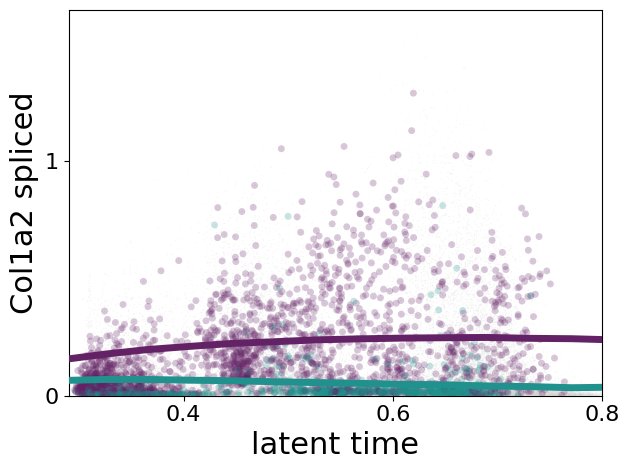

In [100]:
from scipy.stats import binned_statistic

fig,ax=plt.subplots()

x = xhat_dead_traj[:,:,np.where(adata.var.index.values=='Col1a2')[0]][...,0]
t = times[dead_cells,:,0].numpy()[x>-100]
x = x[x>-100]
dead_mean, bin_edges_dead, _ = binned_statistic(t, 
                                        x,statistic=np.mean, bins=20)
    
    
x = xhat_reprogram_traj[:,:,np.where(adata.var.index.values=='Col1a2')[0]][...,0]
t = times[reprogram_cells,:,0].numpy()[x>-100]
x = x[x>-100]
reprogram_mean, bin_edges_reprogram, _ = binned_statistic(t, 
                                        x,statistic=np.mean, bins=20)

plt.plot(bin_edges_dead[1:], dead_mean,
        color=adata.uns['reprogramming_colors'][0], zorder=100, linewidth=5)
plt.plot(bin_edges_reprogram[1:], reprogram_mean,
        color=adata.uns['reprogramming_colors'][1], zorder=100,linewidth=5)

scv.pl.scatter(adata, x='latent_time', y='Col1a2', color='reprogramming',
               ax=ax,show=False, layer='spliced', s=100, alpha=0.25,
              ylabel='Col1a2 spliced', title='',fontsize=22)
plt.ylim(0,)
plt.xlim(0.29,0.8)
plt.tight_layout()
plt.savefig('figures/Col1a2_trajectories_May12.png')
plt.show()

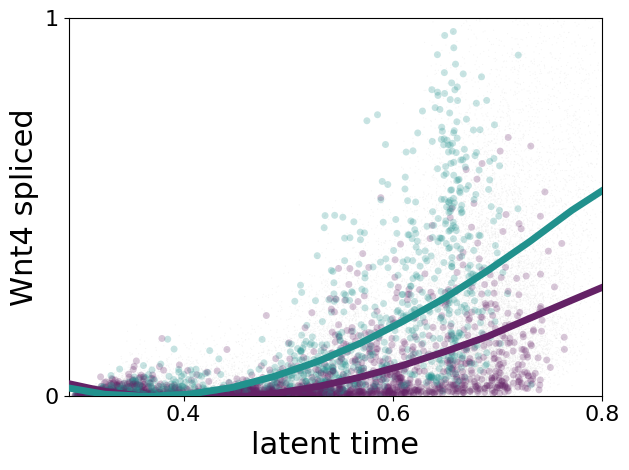

In [101]:
from scipy.stats import binned_statistic

fig,ax=plt.subplots()

x = xhat_dead_traj[:,:,np.where(adata.var.index.values=='Wnt4')[0]][...,0]
t = times[dead_cells,:,0].numpy()[x>-100]
x = x[x>-100]
dead_mean, bin_edges_dead, _ = binned_statistic(t, 
                                        x,statistic=np.mean, bins=20)
    
    
x = xhat_reprogram_traj[:,:,np.where(adata.var.index.values=='Wnt4')[0]][...,0]
t = times[reprogram_cells,:,0].numpy()[x>-100]
x = x[x>-100]
reprogram_mean, bin_edges_reprogram, _ = binned_statistic(t, 
                                        x,statistic=np.mean, bins=20)

plt.plot(bin_edges_dead[1:], dead_mean,
        color=adata.uns['reprogramming_colors'][0], zorder=100, linewidth=5)
plt.plot(bin_edges_reprogram[1:], reprogram_mean,
        color=adata.uns['reprogramming_colors'][1], zorder=100,linewidth=5)

scv.pl.scatter(adata, x='latent_time', y='Wnt4', color='reprogramming',
               ax=ax,show=False, layer='spliced', s=100, alpha=0.25,
              ylabel='Wnt4 spliced', title='',fontsize=22)
plt.ylim(0,1.)
plt.xlim(0.29,0.8)
plt.tight_layout()
plt.savefig('figures/Wnt4_trajectories_May12.png')
plt.show()

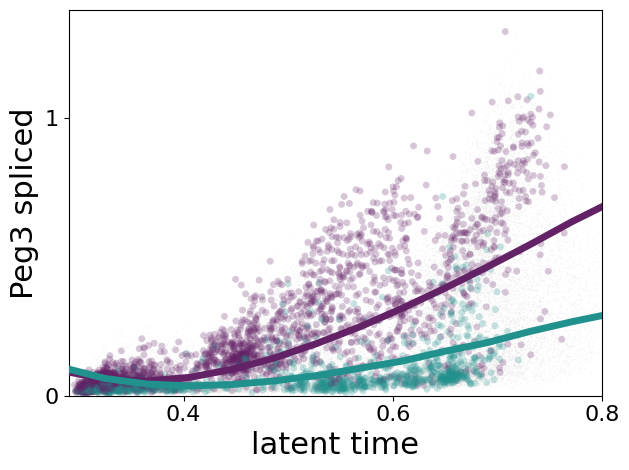

In [102]:
from scipy.stats import binned_statistic

fig,ax=plt.subplots()

x = xhat_dead_traj[:,:,np.where(adata.var.index.values=='Peg3')[0]][...,0]
t = times[dead_cells,:,0].numpy()[x>-100]
x = x[x>-100]
dead_mean, bin_edges_dead, _ = binned_statistic(t, 
                                        x,statistic=np.mean, bins=20)
    
    
x = xhat_reprogram_traj[:,:,np.where(adata.var.index.values=='Peg3')[0]][...,0]
t = times[reprogram_cells,:,0].numpy()[x>-100]
x = x[x>-100]
reprogram_mean, bin_edges_reprogram, _ = binned_statistic(t, 
                                        x,statistic=np.mean, bins=20)

plt.plot(bin_edges_dead[1:], dead_mean,
        color=adata.uns['reprogramming_colors'][0], zorder=100, linewidth=5)
plt.plot(bin_edges_reprogram[1:], reprogram_mean,
        color=adata.uns['reprogramming_colors'][1], zorder=100,linewidth=5)

scv.pl.scatter(adata, x='latent_time', y='Peg3', color='reprogramming',
               ax=ax,show=False, layer='spliced', s=100, alpha=0.25,
              ylabel='Peg3 spliced', title='',fontsize=22)
plt.ylim(0,)
plt.xlim(0.29,0.8)
plt.tight_layout()
plt.savefig('figures/Peg3_trajectories_May12.png')
plt.show()

saving figure to file figures/Mettl7a1_tsne.png


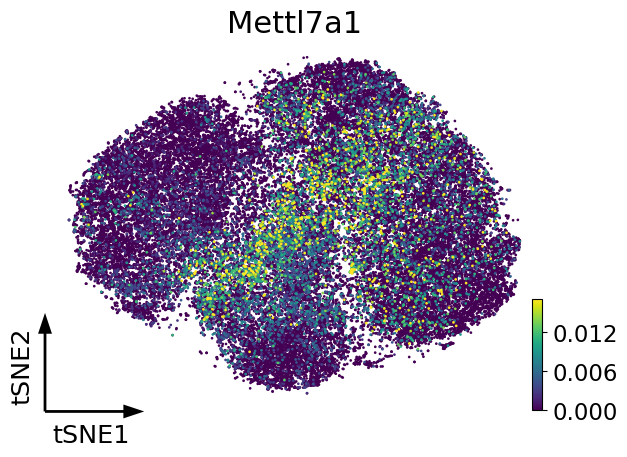

saving figure to file figures/Col1a2_tsne.png


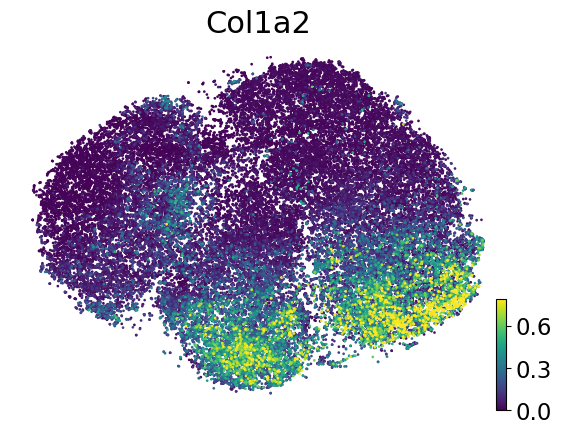

saving figure to file figures/Apoa1_tsne.png


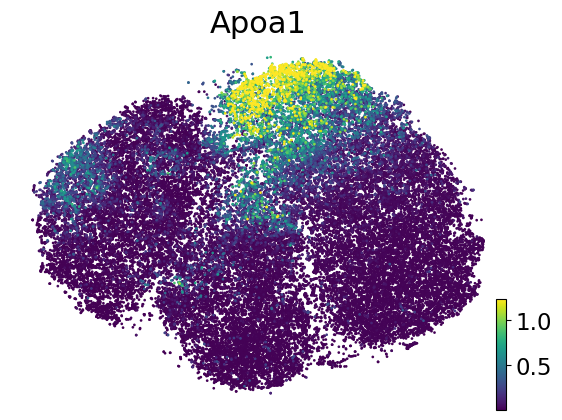

saving figure to file figures/Wnt4_tsne.png


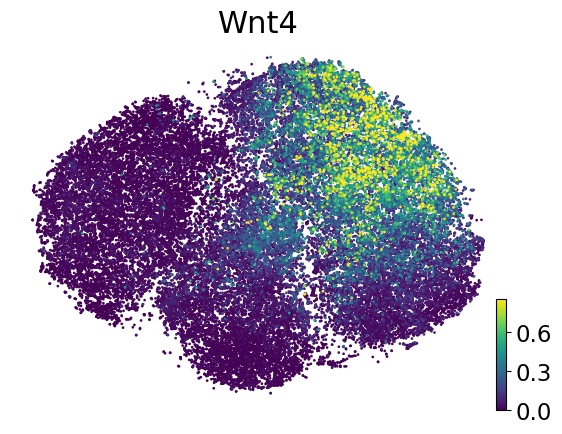

saving figure to file figures/Peg3_tsne.png


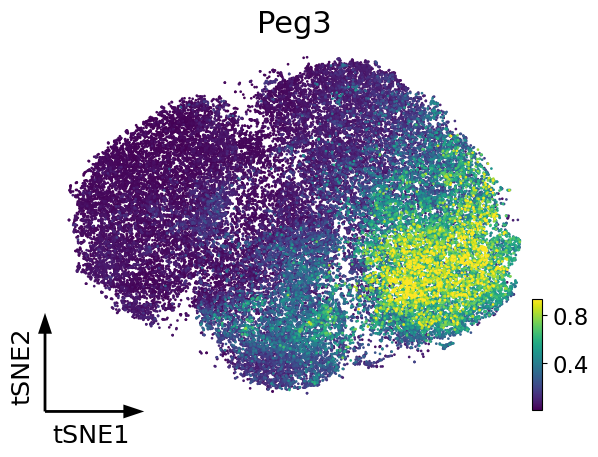

In [103]:
scv.pl.tsne(adata, color='Mettl7a1',s=15, layer='spliced', title='Mettl7a1',save='figures/Mettl7a1_tsne.png',fontsize=22,
            frameon='artist'
    )
scv.pl.tsne(adata, color='Col1a2',s=15, layer='spliced', title='Col1a2',save='figures/Col1a2_tsne.png',fontsize=22)
scv.pl.tsne(adata, color='Apoa1',s=15, layer='spliced', title='Apoa1',save='figures/Apoa1_tsne.png',fontsize=22)
scv.pl.tsne(adata, color='Wnt4',s=15, layer='spliced', title='Wnt4',save='figures/Wnt4_tsne.png',fontsize=22)
scv.pl.tsne(adata, color='Peg3',s=15, layer='spliced', title='Peg3',save='figures/Peg3_tsne.png',fontsize=22,
            frameon='artist')

computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/16 cores)


  0%|          | 0/48515 [00:00<?, ?cells/s]

/home/spencer/.local/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:15) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:08) --> added
    'spliced_velocity_umap_latent', embedded velocity vectors (adata.obsm)


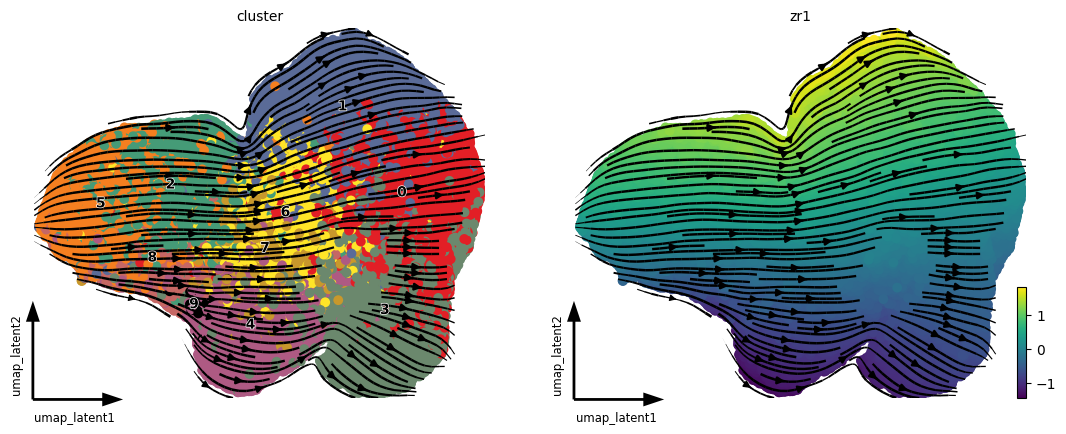

In [104]:
from umap import UMAP
umap = UMAP(n_components=2, min_dist=0.5).fit(latent_adata.X)

transformed = umap.transform(latent_adata.X)
latent_adata.obsm['X_umap_latent'] = transformed
latent_adata.obs['zr1'] = latent_adata.obsm['zr'][:,0]
scv.pp.neighbors(latent_adata, use_rep='X', n_neighbors=30)
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 basis='umap_latent', color=['cluster','zr1'], alpha=1, size=200,
                                frameon='artist')

saving figure to file figures/model_morris_reprogramming_latent_time_latent_umap_May12.png


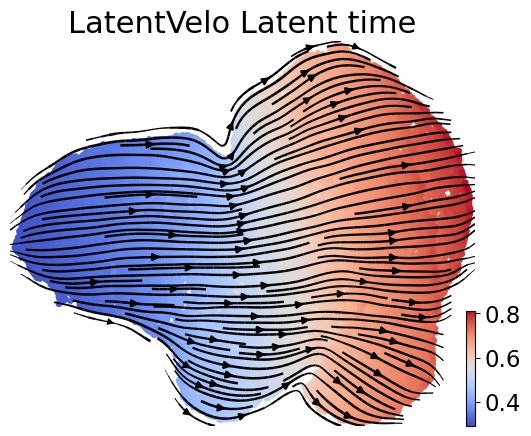

In [105]:
scv.pl.velocity_embedding_stream(latent_adata, basis='umap_latent',vkey='spliced_velocity',
                                 color=['latent_time'], color_map='coolwarm',
                                 title=['LatentVelo Latent time'], cutoff_perc=0,
                                 alpha=1, legend_fontsize=22, legend_fontoutline=3, fontsize=22,
                                figsize=(6,5), save='figures/model_morris_reprogramming_latent_time_latent_umap_May12.png', size=75)

saving figure to file figures/model_morris_reprogramming_latent_umap_May12.png


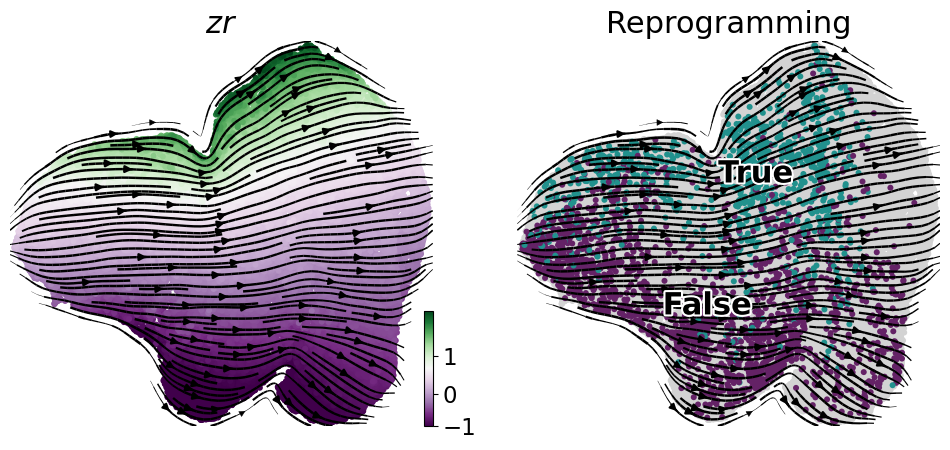

In [106]:
scv.pl.velocity_embedding_stream(latent_adata, basis='umap_latent',vkey='spliced_velocity',
                                color_map='PRGn',
                                 color=['zr1', 'reprogramming'],
                                 title=[r'$z_r$', 'Reprogramming'], 
                                 alpha=1, legend_fontsize=22, legend_fontoutline=3, fontsize=22,
                                 norm=norm, min_mass=0, cutoff_perc=0, size=75, figsize=(6,5),
                                 xlabel='Latent UMAP1', ylabel='Latent UMAP2',
                                save='figures/model_morris_reprogramming_latent_umap_May12.png')

saving figure to file figures/model_morris_zr_latent_umap_May12.png


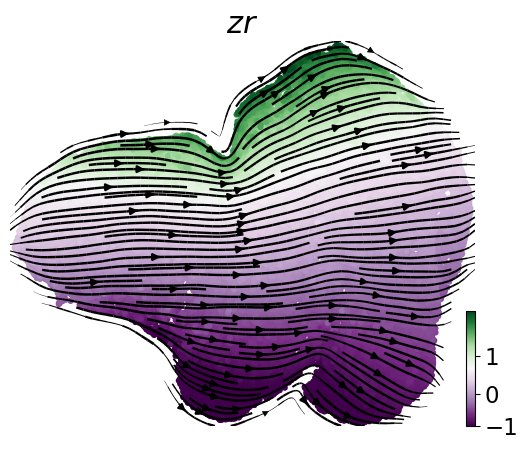

In [107]:
scv.pl.velocity_embedding_stream(latent_adata, basis='umap_latent',vkey='spliced_velocity',
                                color_map='PRGn',
                                 color=['zr1'],
                                 title=[r'$z_r$'], 
                                 alpha=1, legend_fontsize=22, legend_fontoutline=3, fontsize=22,
                                 norm=norm, min_mass=0, cutoff_perc=0, size=75, figsize=(6,5),
                                 xlabel='Latent UMAP1', ylabel='Latent UMAP2',
                                save='figures/model_morris_zr_latent_umap_May12.png')

saving figure to file figures/model_morris_reprogramming_time_coarse_tsne_May12.png


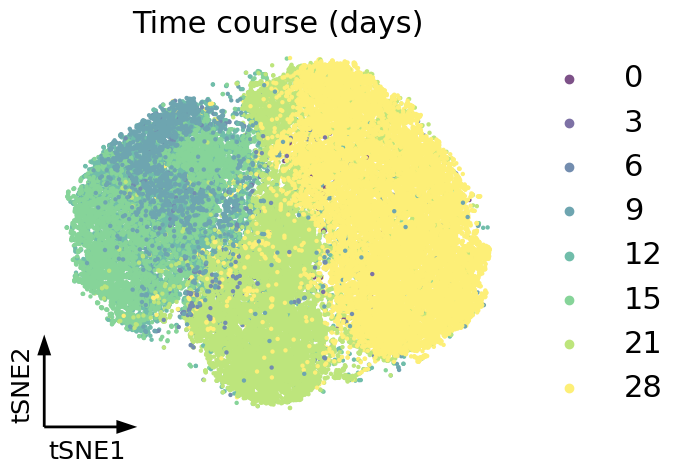

In [108]:
scv.pl.scatter(latent_adata, 'tsne', frameon='artist', color='reprogramming_day',
            title='Time course (days)', figsize=(6,5), fontsize=22, legend_loc='right', 
           save='figures/model_morris_reprogramming_time_coarse_tsne_May12.png', legend_fontsize=22,
           size=40)

saving figure to file figures/model_morris_reprogramming_time_coarse_latent_umap_May12.png


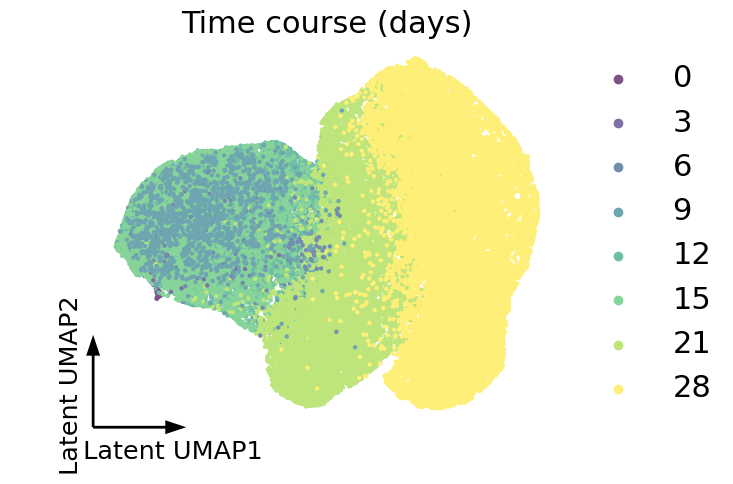

In [110]:
scv.pl.scatter(latent_adata, 'umap_latent', frameon='artist', color='reprogramming_day',
            title='Time course (days)', figsize=(6,5), fontsize=22, legend_loc='right', 
           save='figures/model_morris_reprogramming_time_coarse_latent_umap_May12.png', legend_fontsize=22,
           size=40, xlabel='         Latent UMAP1', ylabel='Latent UMAP2')

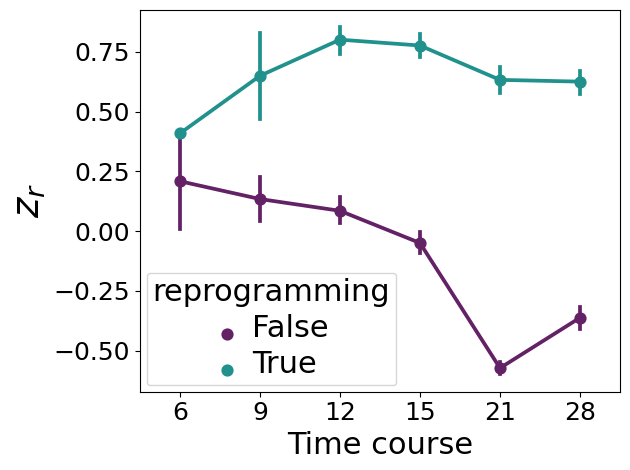

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.pointplot(data=latent_adata.obs, y='zr1', x='reprogramming_day', hue='reprogramming', palette=latent_adata.uns['reprogramming_colors'])
ax.set(xlim=(1.5, 7.5))
ax.set_xlabel('Time course', fontsize=22)
ax.set_ylabel(r'$z_r$', fontsize=28)
ax.tick_params(labelsize=18)
plt.setp(ax.get_legend().get_texts(), fontsize='22')
plt.setp(ax.get_legend().get_title(), fontsize='22')
plt.tight_layout()
plt.savefig('figures/zr_vs_time_course_Mahy12.pdf')
plt.show()

saving figure to file ./figures/scvelo_model_morris_reprogramming_latent_umap_novelo_May12.png


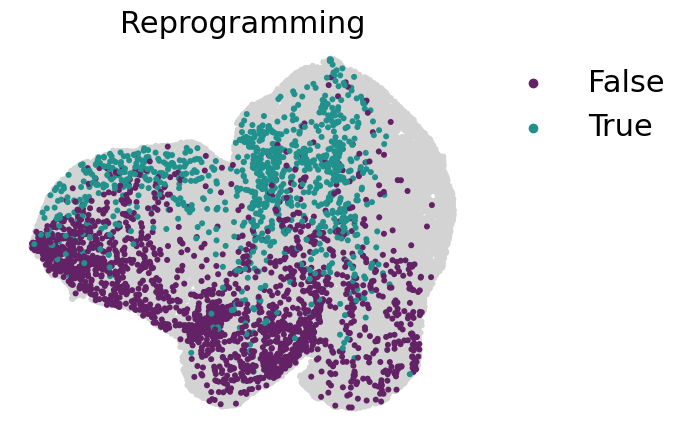

In [112]:
norm = TwoSlopeNorm(0.8, vmin=-1, vmax=1.75)
scv.pl.scatter(latent_adata, basis='umap_latent',
                                color_map='PRGn',
                                 color=['reprogramming'],
                                 title=['Reprogramming'], 
                                 alpha=1, legend_fontsize=22, legend_fontoutline=3, fontsize=22,
                                 norm=norm, size=75, figsize=(6,5),
                                 xlabel='Latent UMAP1', ylabel='Latent UMAP2',
                                save='model_morris_reprogramming_latent_umap_novelo_May12.png')

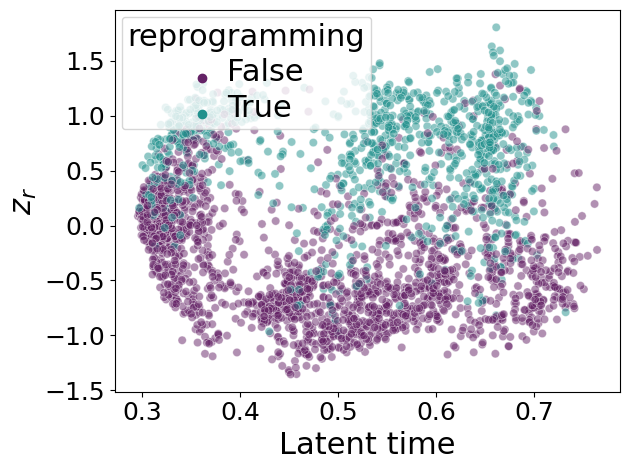

In [113]:
from scipy.stats import binned_statistic

palette = {'False':latent_adata.uns['reprogramming_colors'][0], 'True':latent_adata.uns['reprogramming_colors'][1]}

avg_false, bin_edges,_ = binned_statistic(latent_adata[latent_adata.obs['reprogramming'] == 'False'].obs['latent_time'], 
                                      latent_adata[latent_adata.obs['reprogramming'] == 'False'].obs['zr1'], bins = np.linspace(0, 1, 15))

avg_true, bin_edges,_ = binned_statistic(latent_adata[latent_adata.obs['reprogramming'] == 'True'].obs['latent_time'], 
                                      latent_adata[latent_adata.obs['reprogramming'] == 'True'].obs['zr1'], bins = np.linspace(0, 1, 15))

ax = sns.scatterplot(data=latent_adata.obs, x='latent_time', y='zr1', hue='reprogramming', 
                     palette=palette,alpha=0.5)

ax.set_xlabel('Latent time', fontsize=22)
ax.set_ylabel(r'$z_r$', fontsize=22)
ax.tick_params(labelsize=18)
plt.setp(ax.get_legend().get_texts(), fontsize='22')
plt.setp(ax.get_legend().get_title(), fontsize='22')
plt.tight_layout()
plt.tight_layout()
plt.savefig('figures/zr_vs_latent_time_May12.pdf')
plt.show()

In [115]:
"""
Generating ROC curves. Taken from CellRank https://github.com/theislab/cellrank_reproducibility
"""
from typing import Optional, Sequence, Iterable
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from anndata import AnnData
def predict_reprogramming_outcome(adata: AnnData, 
                                  day_key: str = 'reprogramming_day',
                                  day_selection: Optional[Sequence] = None,
                                  binary_label_key: str = 'reprogramming',
                                  predictor_key: str = 'reprogramming_probability', 
                                  predictor_key2: Optional[str] = None, 
                                  random_state: int = 0, 
                                  figsize: Optional[Iterable[float]] = None, 
                                  lw: float = 2, 
                                  save: Optional[str] = None):
    """
    Predict reprogramming outcome for a subset of labelled cells given fate probabilities. 
    
    Given a subset of days from the reprogramming timecourse, treat the clonal information as ground-truth
    binary labels in a classification task in which we predict reprogramming outcome based on fate probabilities 
    using logistic regression. Data is subsampled so that sucessful/dead-end classes are balanced and split
    into train/test sets. Classification is evaluated using ROC curves. Note that cells used to define the terminal
    states are always removed from training/test sets. 
    
    Parameters
    ----
    adata
        Annotated data matrix.
    day_key
        Key from `.obs` where time-point information can be found.
    day_selection
        Lists of strings representing days that the data should be restricted to. 
    binary_label_key
        Key from `.obs` where the ground truth labels from CellTagging can be found. 
    predictor_key
        Key from `.obs` where the fate probability of sucessful reprogramming can be found.
    random_state
        Random seed used to subsample data.
    figzise
        Size of the overall figure
    save
        Path where figure is to be saved
        
    Returns
    ---
    Noting, just plots the ROC curve. 
    """
    
    # Restrict to cells from selected days that we have labels for
    # Exclude the cells that were used to define the terminal states
    if predictor_key == 'reprogramming_probability':
        if 'terminal_states' not in adata.obs.keys():
            raise ValueError('Compute terminal states first. ')
        terminal_mask = np.sum(adata.obs['terminal_states'].isna())
        label_mask = ~adata.obs[binary_label_key].isna()
        _mask = np.logical_and(terminal_mask, label_mask)
        
    if day_selection is None:
        day_selection = adata.obs[day_key].cat.categories
        
    # get the corresponding colors
    _colors = adata.uns[f"{day_key}_colors"]
    colors = [_colors[np.where(np.in1d(adata.obs[day_key].cat.categories, day))[0][0]] 
                      for day in day_selection]
        
    # initialise figure and axis object
    fig = plt.figure(None, figsize)
    ax = fig.add_subplot(111)
        
    # loop over days
    for day, color in zip(day_selection, colors):
        
        # restrict to current day
        day_mask = np.in1d(adata.obs[day_key], day)
        if predictor_key != 'reprogramming_probability':
            mask = day_mask
        else:
            mask = np.logical_and(_mask, day_mask)
        
        print(f"\nThis selects {np.sum(mask)} cells from day {day}." )

        # For these cells, get data matrices
        
        if predictor_key2 != None:
            data = sc.get.obs_df(adata[mask], keys=[binary_label_key, predictor_key, predictor_key2])
            X = data[[predictor_key, predictor_key2]].values
        else:
            data = sc.get.obs_df(adata[mask], keys=[binary_label_key, predictor_key])
            X = data[predictor_key].values[:, None]
        y = np.array(data[binary_label_key].values) == 'True'
        assert(X.shape[0] == np.sum(mask)), "Shape mismatch between X and number of cells. "

        # Check for inbalanced classes
        print(f"There are {100* np.sum(y == True) / len(y):.2f}% positive examples. Correcting for class inbalance. ")

        # Correct for class inbalance
        np.random.seed(random_state)

        # split the data into positive and negative examples
        positive_mask = y
        X_positive, y_positive = X[positive_mask], y[positive_mask]
        X_negative, y_negative = X[~positive_mask], y[~positive_mask]

        # subsample the negative examples
        neg_ixs = np.random.choice(range(len(y_negative)), size=len(y_positive), replace=False)
        X_negative_sub, y_negative_sub = X_negative[neg_ixs], y_negative[neg_ixs]

        # concatenate positive and subsampled negative examples
        X_balanced = np.concatenate((X_positive, X_negative_sub))
        y_balanced = np.concatenate((y_positive, y_negative_sub))

        # assert that classes are balanced now
        assert(np.sum(y_balanced == True) / len(y_balanced) == 0.5), "Class inbalance could not be fixed. "

        # Split into training/test sets
        X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, random_state=0, test_size=0.1)
        n_data = X_train.shape[0] + X_test.shape[0]
        print(f"There are {X_train.shape[0]}/{n_data} training examples and {X_test.shape[0]}/{n_data} testing examples. ")

        # fit logistic regression classifier and show ROC on test set
        clf = LogisticRegression(random_state=random_state, penalty='none').fit(X_train, y_train)
        metrics.plot_roc_curve(clf, X_test, y_test, ax=ax, name=f"Day {day}", lw=lw, color=color)
    
    #ax.set_xlabel('Reprogramming')
    #ax.set_ylabel(r'$z_r$', fontsize=18)
    ax.tick_params(labelsize=18)
    plt.legend(loc='lower right')#bbox_to_anchor=(1.05, 1.)) 
    ax.set_ylabel('True positive rate', fontsize=22)
    ax.set_xlabel('False positive rate', fontsize=22)
    plt.setp(ax.get_legend().get_texts(), fontsize='22')
    plt.setp(ax.get_legend().get_title(), fontsize='22')
    if save is not None: 
        plt.savefig(save)
    #plt.show()


This selects 6454 cells from day 12.
There are 1.61% positive examples. Correcting for class inbalance. 
There are 187/208 training examples and 21/208 testing examples. 

This selects 6291 cells from day 15.
There are 2.45% positive examples. Correcting for class inbalance. 
There are 277/308 training examples and 31/308 testing examples. 

This selects 12482 cells from day 21.
There are 2.61% positive examples. Correcting for class inbalance. 
There are 586/652 training examples and 66/652 testing examples. 

This selects 20420 cells from day 28.
There are 1.77% positive examples. Correcting for class inbalance. 
There are 649/722 training examples and 73/722 testing examples. 


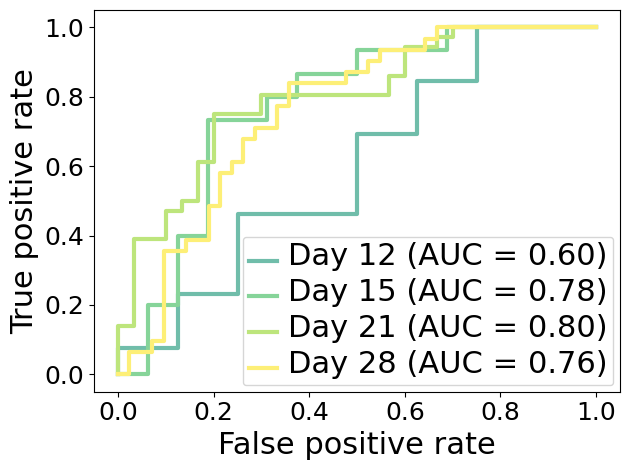

In [116]:
import matplotlib.pyplot as plt
predict_reprogramming_outcome(latent_adata, day_selection=['12', '15', '21', '28'], lw=3, 
                              predictor_key='zr1')
plt.tight_layout()
plt.savefig('figures/ROC_morris_reprogramming_May12.pdf')
plt.show()

# Plot sampled trajectories on latent UMAP|

In [117]:
reprogrammed_ids = []
for i in range(50):
    reprogrammed_ids.append(np.where(latent_adata[selected].obs['latent_time'] == latent_adata[selected][(latent_adata[selected].obs['reprogramming']=='True') & (latent_adata[selected].obs['latent_time']>0.6)].obs['latent_time'][np.argsort(-1*latent_adata[selected][(latent_adata[selected].obs['reprogramming']=='True') & (latent_adata[selected].obs['latent_time']>0.6)].obs['latent_time'])][i])[0][0])

In [118]:
deadend_ids = []
for i in range(50):
    deadend_ids.append(np.where(latent_adata[selected].obs['latent_time'] == latent_adata[selected][(latent_adata[selected].obs['reprogramming']=='False') & (latent_adata[selected].obs['latent_time']>0.6)].obs['latent_time'][np.argsort(-1*latent_adata[selected][(latent_adata[selected].obs['reprogramming']=='False') & (latent_adata[selected].obs['latent_time']>0.6)].obs['latent_time'])][i])[0][0])

saving figure to file figures/reprogramming_dynamics_many_May12.png


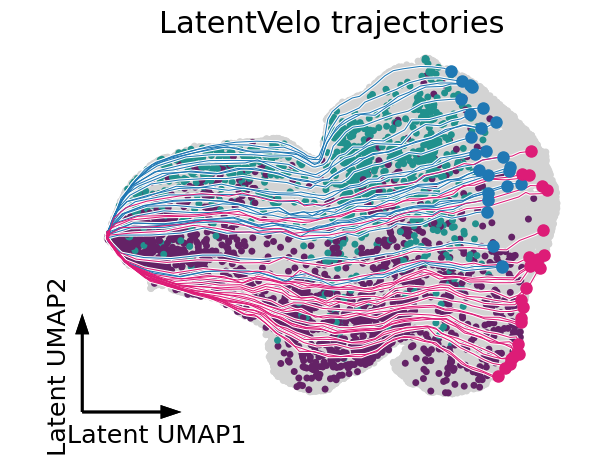

In [121]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()

for j,cell in enumerate(reprogrammed_ids[:25]):
    z_traj_pca = umap.transform(z_traj[cell,times[cell,:,0]<=latent_adata[selected].obs.latent_time[cell]+0.05,:20].detach().cpu().numpy())

    plt.plot(z_traj_pca[:,0], z_traj_pca[:,1], color='#1f78b4', linewidth=0.75, zorder=100)
    plt.plot(z_traj_pca[:,0], z_traj_pca[:,1], color='white', linewidth=2.25, zorder=10)
    plt.plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color='#1f78b4', linewidth=3, marker='o', markersize=8,
            zorder=1000)

for j,cell in enumerate(deadend_ids[:25]):
    z_traj_pca = umap.transform(z_traj[cell,times[cell,:,0]<=latent_adata[selected].obs.latent_time[cell]+0.05,:20].detach().cpu().numpy())

    plt.plot(z_traj_pca[:,0], z_traj_pca[:,1], color='#dd1c77', linewidth=0.75, zorder=100)
    plt.plot(z_traj_pca[:,0], z_traj_pca[:,1], color='white', linewidth=2.25, zorder=10)
    plt.plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color='#dd1c77', linewidth=3, marker='o', markersize=8,
            zorder=1000)
    
scv.pl.scatter(latent_adata, 'umap_latent', frameon='artist', ax=ax, color='reprogramming',size=100,
              xlabel='       Latent UMAP1', ylabel='Latent UMAP2', legend_loc='none', title='LatentVelo trajectories', fontsize=22, save='figures/reprogramming_dynamics_many_May12.png')
plt.show()